# PCA Yemen samples - Context: Reich (Allen Datasets)

169 Yemen samples as well as samples from Chad and Pakistan are used.
The Reich (Allen) datasets contain many samples from countries surrounding the Arabian Peninsula (amongst many others). 
See table below. This context data is taken from the [Reich lab](https://reich.hms.harvard.edu/allen-ancient-dna-resource-aadr-downloadable-genotypes-present-day-and-ancient-dna-data) web page.
The overlaps in terms of nr of variants between the various contexts


|Study | Context | Overlap|
|---|---|---|
|Yemen | HGDP |329K|
|Yemen | Reich "1240K" | 358K|
|Yemen | Reich Human Origins | 118K|
|yemen| ukb| 91741|
|uae| ukb| 132315|
|yemen| uae| 609685|
|uae| hgdp| 552476|
|uae| reichHO| 179364|
|uae| reich1240K|   596568|


|1. Study | 2. Study | Context | Overlap|
|---|---|---|---|
|yemen| uae| hgdp| 328303|  
|yemen| uae| reichHO | 118080|
|yemen| uae| reich1240K| 358610|
|yemen| uae| ukb |91473|




## Data preprocessing:
### Merging datasets for contextualization
* Identify overlaps (purely based on rs-IDs), create *.snps files (see variantIntersections2.py)
* Plink based dataset merging, see runPCA.sh
* Conduct PCA: Docker/flashPCA, see Syafiq's wiki 

In [99]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook

### Comparison between the two Reich datasets
The 1240K+HO (including "Human Origins" has far more data from nearby countries. Downside: variant overlap drops considerably

In [100]:
pd.read_csv('Reich/reich1240K_vs_HO.csv', sep='\t')

,Country,ReichHO,1240K
0,Ethiopia,13,1
1,Israel,369,236
2,Jordan,49,39
3,Lebanon,65,37
4,Sudan,4,1
5,Syria,24,16
6,Yemen,107,2


## Yemen metadata
Extract region information. To be combined with context metadata, and appended to PCA table.

In [101]:
import re
def readZallouaMetadata(manifest, selcols):    
    regionalContext = pd.read_csv(manifest, skiprows=8, sep=',', skip_blank_lines=True)
    regionalContext = regionalContext.iloc[:,selcols]
    regionalContext.columns = 'Id RegionId'.split()
    regionalContext.set_index('Id', inplace=True)
    return regionalContext.dropna(subset=['RegionId'])

yemenMeta = readZallouaMetadata("Metadata/3577stdy_manifest_3450_190315.csv.gz", [2,3])

## some cleanup
yemenMeta["Region"] = [re.findall('\D+', sup)[0] for sup in yemenMeta['RegionId']]
yemenMeta = yemenMeta[['Region']]
yemenMeta = yemenMeta[yemenMeta.Region!='Empty']
print (Counter(yemenMeta.Region))


Counter({'Rsa': 48, 'Ibb': 25, 'Hdr': 25, 'Tiz': 24, 'Dhm': 10, 'Abyn': 10, 'Sad': 10, 'Mhw': 10, 'Lahj': 10, 'Jwf': 10, 'San': 10, 'Mrb': 10, 'Amr': 10, 'Haj': 10, 'Shb': 10, 'Dal': 9, 'Byd': 7})


In [102]:
yemenMeta.to_csv('Metadata/yemenRegions.csv')

In [103]:
# Chad/Pakistan context - loading Metadata
chadContext = readZallouaMetadata("Metadata/yemcha_manifest_3558_160415.csv.gz", [2,8])
pakistan = readZallouaMetadata("Metadata/sc_egyptlc_manifest_1764_050613.csv.gz", [2,8])
pd.concat([yemenMeta, chadContext, pakistan])


,Region,RegionId
Id,,
3577STDY6068360,Dal,NaN
3577STDY6068361,Ibb,NaN
3577STDY6068362,Rsa,NaN
3577STDY6068363,Rsa,NaN
3577STDY6068364,Rsa,NaN
...,...,...
SC_EGYPTLC5544425,NaN,Pakistan
SC_EGYPTLC5544426,NaN,Pakistan
SC_EGYPTLC5544427,NaN,Pakistan


## Reich: Dataset 1240K+HO (Ancient DNA + Human Origins)
Context is large (13K samples) and we downsample (but PCA is done on all samples). 
Downsampling policy: randomly pick 107 samples from closeby countries (relevance=1), radnomly pick 50 from any other country.

In [104]:
reichMeta=pd.read_csv("Reich/v44.3_HO_public.anno", sep='\t')
reichMeta.columns = ['Index', 'Id', 'Id2',
       'Publication', 'contact',
       'Date',
       'Full_Date',
       'Group_Label', 'Locality', 'Region', 'Lat', 'Long',
       'Data source', 'Cov_autosm',
       'SNPs_autosm', 'Sex',
       'Library_type',
       'ASSESSMENT']
reichMeta
## Ancient DNA filter
reichMetaAncient = reichMeta[((reichMeta.Date>3000) & (reichMeta.SNPs_autosm>100000))]#sort_values(by='Date', ascending=False).head(20)
sum(Counter(reichMetaAncient.Group_Label).values())
reichMetaAncient = reichMetaAncient[['Id','Group_Label']].set_index('Id')
reichMetaAncient.columns = ['Region']
reichMetaAncient.head()

,Region
Id,
I1781,Turkmenistan_Gonur_BA_1
I1782,Turkmenistan_Gonur_BA_1
I1788,Turkmenistan_Gonur_BA_1
I1790,Turkmenistan_Gonur_BA_1
I2116,Turkmenistan_Gonur_BA_1


In [105]:
## rich annotation, for the time being, just selecting country (region)

reichMeta = reichMeta[['Id','Region','Group_Label']].set_index('Id')
countryStats = Counter(reichMeta.Region)


### Thinning the context
As >13K data points would be hard to plot, we randomly downsample them. In addition we filter by only choosing from close countries (closeContext).


In [30]:
closeContext = 'Ethiopia,Lebanon,Eritrea,Israel,Sudan,Syria,Yemen,Jordan,Iraq,Iran,Egypt,Saudi Arabia'.split(',')
def relevance(country):
    if country =='Yemen': return 2
    if country in closeContext: return 1
    return 0
def downsample(country, caps=[20, 50, 107]):
    df = reichMeta[reichMeta.Region==country]
    samplesize = caps[relevance(country)]
    if samplesize < df.shape[0]:
        return df.sample(samplesize)
    return df 

selCountries = 'Armenia,Ukraine,Pakistan,Turkey,Congo,Italy,China,Morocco,India,Tunisia'.split(',') + closeContext
reichMeta50 = pd.concat([downsample(country, [10, 25, 107]) for country in countryStats if country in selCountries])
Counter(reichMeta.Region).most_common()

[('Russia', 1705),
 ('China', 1083),
 ('Spain', 680),
 ('Pakistan', 633),
 ('Italy', 538),
 ('USA', 446),
 ('Great Britain', 412),
 ('Israel', 369),
 ('Germany', 356),
 ('Nigeria', 352),
 ('France', 286),
 ('India', 254),
 ('Turkey', 240),
 ('Kenya', 220),
 ('Hungary', 215),
 ('Sweden', 193),
 ('Japan', 176),
 ('Peru', 170),
 ('Kazakhstan', 166),
 ('Vietnam', 148),
 ('Mongolia', 139),
 ('Puerto Rico', 130),
 ('Iran', 128),
 ('Dominican Republic', 127),
 ('Mexico', 123),
 ('Finland', 122),
 ('Gambia', 121),
 ('Uzbekistan', 113),
 ('Poland', 110),
 ('Colombia', 108),
 ('Yemen', 107),
 ('Sri Lanka', 103),
 ('Ukraine', 98),
 ('Estonia', 96),
 ('Bangladesh', 96),
 ('Barbados', 96),
 ('Sierra Leone', 95),
 ('Denmark', 95),
 ('Turkmenistan', 92),
 ('Czech Republic', 87),
 ('Switzerland', 80),
 ('Papua New Guinea', 76),
 ('Brazil', 72),
 ('Greece', 69),
 ('Taiwan', 69),
 ('Algeria', 66),
 ('Nepal', 66),
 ('Lebanon', 65),
 ('Ireland', 63),
 ('Bulgaria', 58),
 ('Iceland', 58),
 ('Cuba', 58),
 ('

In [31]:
#Simple combination
## change this 
meta = pd.concat([yemenMeta, reichMetaAncient]) #reichMeta50])
meta

,Region
Id,
3577STDY6068360,Dal
3577STDY6068361,Ibb
3577STDY6068362,Rsa
3577STDY6068363,Rsa
3577STDY6068364,Rsa
...,...
PN12.SG,Ireland_MN.SG
PN13.SG,Ireland_EN_MN.SG
PN16.SG,Ireland_MN.SG


In [32]:
from myutils import colors, colors2, markers

### Loading PCA data
The merged dataset was subjected to Flash-PCA. Combined dataset shown below.

In [106]:
pca = pd.read_csv(f'FlashPCAResults/YemenReichHO/pcs.txt', delimiter='\t')


In [107]:
ids = [iid.split('_')[-1] for iid in pca['IID']]
pca['FID1'] = ids
pca.set_index('FID1', inplace=True)
pca

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
FID1,,,,,,,,,,,,
MAL-005,1,MAL-005,-0.668563,-0.186939,-0.012376,-0.008212,0.002309,-0.016566,-0.028582,0.014858,0.011621,-0.004653
MAL-009,2,MAL-009,-0.652698,-0.185005,-0.006781,-0.010956,-0.005993,-0.021205,-0.020280,0.004516,0.008802,-0.006408
MAL-011,3,MAL-011,-0.671137,-0.187152,-0.009245,-0.013635,0.005009,-0.013627,-0.014207,0.006091,0.016281,-0.007094
MAL-012,4,MAL-012,-0.665634,-0.184766,-0.006079,-0.004144,0.000172,-0.016001,-0.032014,0.008432,0.020338,-0.012785
MAL-014,5,MAL-014,-0.667511,-0.187095,-0.004709,-0.011141,-0.004765,-0.018777,-0.034707,0.002222,0.002565,-0.007879
...,...,...,...,...,...,...,...,...,...,...,...,...
3577STDY6068568,urn:wtsi:402769_H09_3577STDY6068568,urn:wtsi:402769_H09_3577STDY6068568,-0.139141,0.127716,0.040863,0.011073,-0.116100,0.046633,0.016714,0.062719,0.005606,-0.013736
3577STDY6068600,urn:wtsi:402769_H10_3577STDY6068600,urn:wtsi:402769_H10_3577STDY6068600,-0.082048,0.159256,0.038233,0.003569,-0.128213,0.042367,0.025431,0.069612,0.009617,-0.010890
3577STDY6068625,urn:wtsi:402769_H11_3577STDY6068625,urn:wtsi:402769_H11_3577STDY6068625,-0.109379,0.145012,0.041254,0.007771,-0.127986,0.046414,0.022386,0.074517,0.011113,-0.008102


### Including admix data, concat dataframes

In [108]:
k = 12
admix =  "Admixture/YemenHO/yemen_clean_reichHO4.%s.Q" % k
q = pd.read_csv(admix, header=None, sep=' ')
q.index = pca.index
pops = ['Pop%02d'%i for i in range(k)]
q.columns = pops
q

,Pop00,Pop01,Pop02,Pop03,Pop04,Pop05,Pop06,Pop07,Pop08,Pop09,Pop10,Pop11
FID1,,,,,,,,,,,,
MAL-005,0.000010,0.000010,0.000010,0.000010,0.000010,0.028327,0.000010,0.000010,0.003226,0.955406,0.000010,0.012962
MAL-009,0.000010,0.000477,0.000010,0.000010,0.000010,0.027632,0.000010,0.000012,0.002015,0.954374,0.000010,0.015430
MAL-011,0.000963,0.006671,0.000010,0.000834,0.000010,0.036228,0.000010,0.000010,0.000010,0.950177,0.000010,0.005068
MAL-012,0.000010,0.000010,0.000010,0.003965,0.004643,0.022376,0.000010,0.000010,0.000010,0.960076,0.000010,0.008871
MAL-014,0.000087,0.002577,0.000010,0.000010,0.000010,0.021992,0.000010,0.000010,0.000010,0.965851,0.000010,0.009423
...,...,...,...,...,...,...,...,...,...,...,...,...
3577STDY6068568,0.037113,0.002255,0.001714,0.017097,0.015108,0.006066,0.017859,0.203411,0.000010,0.192776,0.000491,0.506100
3577STDY6068600,0.027027,0.027276,0.003619,0.005126,0.024519,0.001236,0.010862,0.235752,0.019285,0.119312,0.000010,0.525975
3577STDY6068625,0.025257,0.016251,0.002803,0.015455,0.007714,0.000010,0.002243,0.222281,0.017475,0.157613,0.000010,0.532887


### Concatenating PCA and Admixture data
Based on the assumption that sample order is maintained, we simply stack dataframes horizontally
TODO: run smartPCA 

In [109]:
pca = pd.concat([pca, q], axis=1)
pca

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,Pop02,Pop03,Pop04,Pop05,Pop06,Pop07,Pop08,Pop09,Pop10,Pop11
FID1,,,,,,,,,,,,,,,,,,,,,
MAL-005,1,MAL-005,-0.668563,-0.186939,-0.012376,-0.008212,0.002309,-0.016566,-0.028582,0.014858,...,0.000010,0.000010,0.000010,0.028327,0.000010,0.000010,0.003226,0.955406,0.000010,0.012962
MAL-009,2,MAL-009,-0.652698,-0.185005,-0.006781,-0.010956,-0.005993,-0.021205,-0.020280,0.004516,...,0.000010,0.000010,0.000010,0.027632,0.000010,0.000012,0.002015,0.954374,0.000010,0.015430
MAL-011,3,MAL-011,-0.671137,-0.187152,-0.009245,-0.013635,0.005009,-0.013627,-0.014207,0.006091,...,0.000010,0.000834,0.000010,0.036228,0.000010,0.000010,0.000010,0.950177,0.000010,0.005068
MAL-012,4,MAL-012,-0.665634,-0.184766,-0.006079,-0.004144,0.000172,-0.016001,-0.032014,0.008432,...,0.000010,0.003965,0.004643,0.022376,0.000010,0.000010,0.000010,0.960076,0.000010,0.008871
MAL-014,5,MAL-014,-0.667511,-0.187095,-0.004709,-0.011141,-0.004765,-0.018777,-0.034707,0.002222,...,0.000010,0.000010,0.000010,0.021992,0.000010,0.000010,0.000010,0.965851,0.000010,0.009423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577STDY6068568,urn:wtsi:402769_H09_3577STDY6068568,urn:wtsi:402769_H09_3577STDY6068568,-0.139141,0.127716,0.040863,0.011073,-0.116100,0.046633,0.016714,0.062719,...,0.001714,0.017097,0.015108,0.006066,0.017859,0.203411,0.000010,0.192776,0.000491,0.506100
3577STDY6068600,urn:wtsi:402769_H10_3577STDY6068600,urn:wtsi:402769_H10_3577STDY6068600,-0.082048,0.159256,0.038233,0.003569,-0.128213,0.042367,0.025431,0.069612,...,0.003619,0.005126,0.024519,0.001236,0.010862,0.235752,0.019285,0.119312,0.000010,0.525975
3577STDY6068625,urn:wtsi:402769_H11_3577STDY6068625,urn:wtsi:402769_H11_3577STDY6068625,-0.109379,0.145012,0.041254,0.007771,-0.127986,0.046414,0.022386,0.074517,...,0.002803,0.015455,0.007714,0.000010,0.002243,0.222281,0.017475,0.157613,0.000010,0.532887


In [110]:
ddf = pca.join(meta).dropna(subset=['Region'])
x = ddf[['PC1', 'PC2']].values
y = ddf['Region'].values

In [111]:
ddf.shape

(2105, 25)

In [75]:


pop1 = 'Dal'
pop2 = 'Dhm'



0.05662710394909621

In [76]:
def popdistance(pop1, pop2):
    pop1DF = ddf[ddf.Region==pop1]
    pop2DF = ddf[ddf.Region==pop2]
    #ddf['PCdist'] = [distance.euclidean(yemenCentroid, row.iloc[2:10]) for idx,row in ddf.iterrows()]

    XA = pop1DF.iloc[:,2:12].to_numpy()
    XB = pop2DF.iloc[:,2:12].to_numpy()
    return distance.cdist(XA, XB, 'euclidean').mean()    

In [80]:
popdistance('Armenia_C', 'Armenia_EBA')

0.042618112521907364

In [92]:
import numpy as np

pops = sorted(Counter(ddf.Region))
D = np.zeros((len(pops),len(pops)))
for i1 in range(len(pops)):
    for i2 in range(i1+1, len(pops)):
        D[i1,i2] = popdistance(pops[i1], pops[i2])


In [96]:
with open('populationDistance.npy','wb') as popD:
    np.save(popD, D)


In [ ]:
D += D.T
D1 = pd.DataFrame(D, index=pops, columns=pops)

In [112]:
D1.to_csv('distanceMatrix_thinnedContext.csv')

<IPython.core.display.Javascript object>


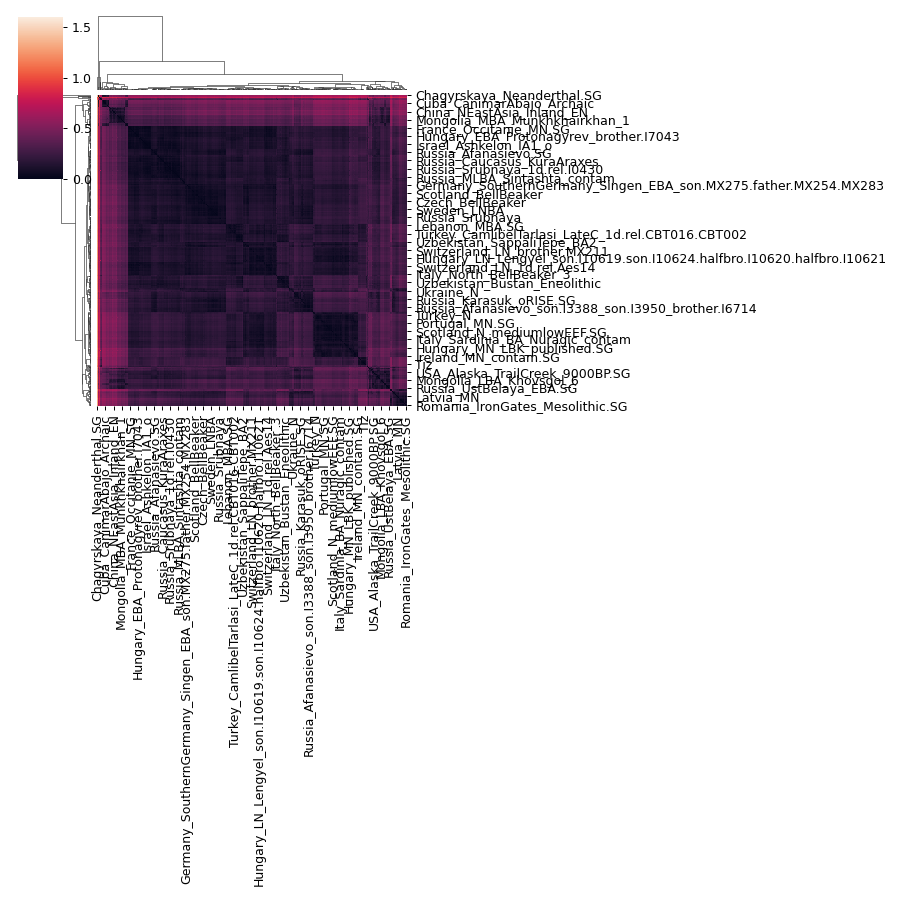

/bmshare/ahenschel/gemini/anaconda/envs/impute/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/bmshare/ahenschel/gemini/anaconda/envs/impute/lib/python3.6/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


In [98]:
import seaborn as sns
sns.clustermap(D1)

In [39]:
from math import pi
from bokeh.palettes import Category20c, Paired


In [40]:
from bokeh.io import output_notebook
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.transform import cumsum

output_notebook()

x_range=ddf.PC1.min(),ddf.PC1.max()
y_range=ddf.PC2.min(),ddf.PC2.max()

Loading BokehJS ...

In [41]:
colorDict = dict(zip(pops, Paired[k]))

In [47]:
yemeni = ddf[ddf.apply(lambda sample: sample.Region in markers.keys(), axis=1)]
sortedPops = yemeni[pops].sum(axis=0).sort_values(ascending=False).keys()
colorsAdmix = [colorDict[pop] for pop in sortedPops]

yemeniS = yemeni[sortedPops].sort_values(by=list(sortedPops), ascending=False)
sortedPops

Index(['Pop11', 'Pop07', 'Pop09', 'Pop00', 'Pop04', 'Pop01', 'Pop10', 'Pop02',
       'Pop08', 'Pop03', 'Pop06', 'Pop05'],
      dtype='object')

<IPython.core.display.Javascript object>


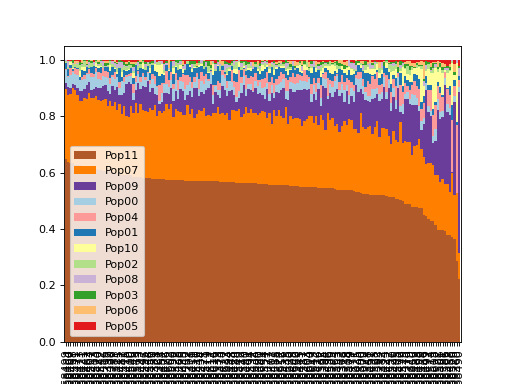

In [19]:
ax=yemeniS.plot.bar(stacked=True, color=colorsAdmix, width=1)
#sort_values(by=pops)

### Yemen data in Reich (Vyas mainly)

In [49]:
yemeni = ddf[ddf.Region=='Yemen']
yemeniS = yemeni[sortedPops].sort_values(by=list(sortedPops), ascending=False)
ddf

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,Pop03,Pop04,Pop05,Pop06,Pop07,Pop08,Pop09,Pop10,Pop11,Region
19651.SG,11023,19651.SG,0.140857,-0.160033,-0.223744,0.002905,0.004983,-0.007200,0.006619,0.016200,...,0.001885,0.041284,0.000562,0.022495,0.000010,0.232955,0.000010,0.000010,0.000010,Canada_BigBar_5700BP.SG
3577STDY6068360,urn:wtsi:402768_A04_3577STDY6068360,urn:wtsi:402768_A04_3577STDY6068360,0.040019,0.129034,0.024720,0.075059,-0.045210,-0.028730,0.011798,0.021927,...,0.000010,0.241095,0.000010,0.000010,0.241566,0.010580,0.000010,0.209171,0.286707,Dal
3577STDY6068363,urn:wtsi:402768_B04_3577STDY6068363,urn:wtsi:402768_B04_3577STDY6068363,-0.081108,0.166468,0.042266,0.014726,-0.131718,0.043034,0.019084,0.056632,...,0.004235,0.031158,0.000010,0.014886,0.228387,0.000010,0.115170,0.014057,0.539281,Rsa
3577STDY6068364,urn:wtsi:402768_C04_3577STDY6068364,urn:wtsi:402768_C04_3577STDY6068364,-0.089888,0.167659,0.036224,0.012653,-0.131091,0.043207,0.024396,0.061888,...,0.003357,0.017301,0.004249,0.002878,0.226198,0.000010,0.118692,0.018615,0.541203,Rsa
3577STDY6068366,urn:wtsi:402768_D04_3577STDY6068366,urn:wtsi:402768_D04_3577STDY6068366,0.016327,0.123590,0.018694,0.046293,-0.058834,-0.005855,0.013593,0.028394,...,0.000010,0.185189,0.000010,0.000010,0.227247,0.002731,0.002764,0.146307,0.371392,Abyn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
poz81.SG,11987,poz81.SG,0.042353,0.126282,-0.026312,0.009439,0.077766,-0.051071,-0.012013,-0.028463,...,0.008262,0.477911,0.001701,0.000010,0.260567,0.003590,0.016027,0.010964,0.000010,Poland_CWC.SG
rath1.SG,5080,rath1.SG,0.052942,0.223897,-0.013478,-0.041667,0.079312,-0.022244,-0.010980,-0.039724,...,0.001246,0.314937,0.000010,0.005718,0.359917,0.017595,0.008318,0.000010,0.000010,Ireland_EBA.SG
rath2.SG,5081,rath2.SG,0.029551,0.178434,-0.007878,-0.029040,0.062152,-0.003564,-0.012718,-0.027770,...,0.019083,0.278898,0.004438,0.002520,0.337496,0.000010,0.024586,0.000010,0.013388,Ireland_EBA.SG
rath3.SG,5082,rath3.SG,0.024540,0.138207,-0.004657,-0.023423,0.042051,-0.004611,-0.014155,-0.023225,...,0.008073,0.295412,0.000010,0.000010,0.358752,0.000010,0.014472,0.000010,0.000010,Ireland_EBA.SG


<IPython.core.display.Javascript object>


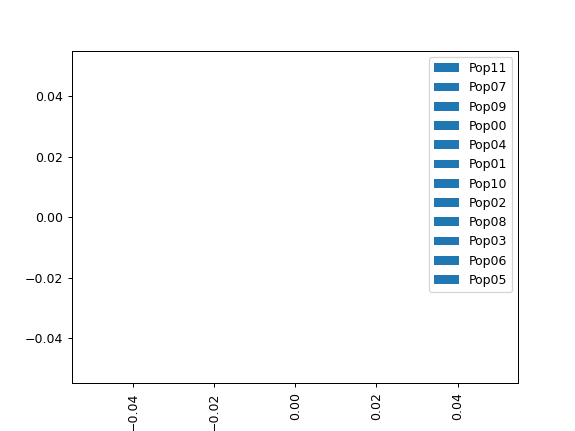

IndexError: index 0 is out of bounds for axis 0 with size 0

In [44]:
ax=yemeniS.plot.bar(stacked=True, color=colorsAdmix, width=1)

### Admixture of world wide context (regional  + few selected far locations)

In [50]:
countriesSortedGeo =  [ ('China', 10), ('India', 10), ('Pakistan', 10), ('Iran', 25), ('Iraq', 14), ('Saudi Arabia', 10),  ('Israel', 25), ('Lebanon', 25), ('Jordan', 25), ('Syria', 24), ('Morocco', 10), ('Tunisia', 10), ('Egypt', 25), ('Ethiopia', 13), ('Sudan', 4), ('Eritrea', 3), ('Armenia', 10), ('Turkey', 10), ('Ukraine', 10), ('Italy', 10), ('Congo', 10)]
others = pd.concat([ddf[ddf.Region==country] for country, _ in countriesSortedGeo])
others

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,Pop03,Pop04,Pop05,Pop06,Pop07,Pop08,Pop09,Pop10,Pop11,Region


<IPython.core.display.Javascript object>


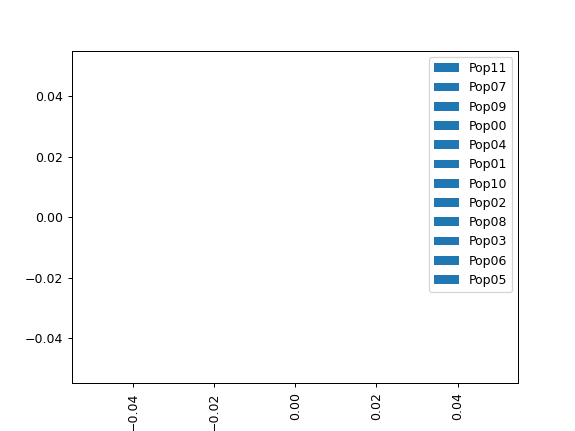

IndexError: index 0 is out of bounds for axis 0 with size 0

In [46]:
others = others.iloc[::2].set_index('Region')
#others = others.sort_values(by=list(sortedPops), ascending=False).set_index('Region')
others[sortedPops].plot.bar(stacked=True, color=colorsAdmix, width=1)

In [22]:
sortedPops

Index(['Pop11', 'Pop07', 'Pop09', 'Pop00', 'Pop04', 'Pop01', 'Pop10', 'Pop02',
       'Pop08', 'Pop03', 'Pop06', 'Pop05'],
      dtype='object')

In [23]:
p = figure(plot_height=1200, plot_width=1600, title="PCA + Admixture", x_range=x_range, y_range=y_range,
    tooltips=[("@pop", "@value"), ("Sample", "@sample"), ("Region", "@region")])
# one pie chart per sample:
# taking a row from the master table -> df, adding some convenience columns
for sample in list(ddf.index):
    region = ddf.loc[sample, 'Region']
    #if not region in markers.keys(): continue
    data = ddf.loc[sample, pops].reset_index(name='value').rename(columns={'index':'pop'})
    data['angle'] = data['value']/data['value'].sum() * 2*pi
    data['color'] = Paired[k]
    data['sample'] = sample
    data['line_color'] = colors2[region]
    data['region'] = region
    x = ddf.loc[sample, 'PC1']
    y = ddf.loc[sample, 'PC2']
    radius = 0.002 if region in markers.keys() else 0.001
        
    p.wedge(x=x, y=y, radius=radius,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color='line_color', fill_color='color',  line_width=3, source=data)
   

show(p)

KeyError: 'Canada_BigBar_5700BP.SG'

In [42]:
yemenCentroid = ddf[ddf.index.str.startswith('3577')].iloc[:,2:10].mean()

In [43]:
from scipy.spatial import distance
ddf['PCdist'] = [distance.euclidean(yemenCentroid, row.iloc[2:10]) for idx,row in ddf.iterrows()]
ddf[ddf.index.str.startswith('3577')].sort_values(by="PCdist", ascending=False)
ddf = ddf[(ddf.PCdist<0.12) | (ddf.index.str.startswith('3577'))] ## everything close to the Yemen centroid
ddf

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,Pop04,Pop05,Pop06,Pop07,Pop08,Pop09,Pop10,Pop11,Region,PCdist
3577STDY6068360,urn:wtsi:402768_A04_3577STDY6068360,urn:wtsi:402768_A04_3577STDY6068360,0.040019,0.129034,0.024720,0.075059,-0.045210,-0.028730,0.011798,0.021927,...,0.241095,0.000010,0.000010,0.241566,0.010580,0.000010,0.209171,0.286707,Dal,0.177925
3577STDY6068363,urn:wtsi:402768_B04_3577STDY6068363,urn:wtsi:402768_B04_3577STDY6068363,-0.081108,0.166468,0.042266,0.014726,-0.131718,0.043034,0.019084,0.056632,...,0.031158,0.000010,0.014886,0.228387,0.000010,0.115170,0.014057,0.539281,Rsa,0.020844
3577STDY6068364,urn:wtsi:402768_C04_3577STDY6068364,urn:wtsi:402768_C04_3577STDY6068364,-0.089888,0.167659,0.036224,0.012653,-0.131091,0.043207,0.024396,0.061888,...,0.017301,0.004249,0.002878,0.226198,0.000010,0.118692,0.018615,0.541203,Rsa,0.023974
3577STDY6068366,urn:wtsi:402768_D04_3577STDY6068366,urn:wtsi:402768_D04_3577STDY6068366,0.016327,0.123590,0.018694,0.046293,-0.058834,-0.005855,0.013593,0.028394,...,0.185189,0.000010,0.000010,0.227247,0.002731,0.002764,0.146307,0.371392,Abyn,0.140321
3577STDY6068367,urn:wtsi:402768_E04_3577STDY6068367,urn:wtsi:402768_E04_3577STDY6068367,-0.016454,0.173945,0.033367,0.028361,-0.122320,0.030789,0.031928,0.062608,...,0.055599,0.003172,0.000010,0.240484,0.003779,0.026177,0.039694,0.577682,Sad,0.055019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I6569,8575,I6569,-0.000738,0.131144,0.025519,-0.005056,-0.076262,0.029624,0.019404,0.032771,...,0.125815,0.000661,0.004805,0.010209,0.000010,0.000010,0.000010,0.472689,Jordan_LBA,0.103683
I6570,8576,I6570,-0.001408,0.162615,0.031066,0.000682,-0.076934,0.040583,0.018459,0.043162,...,0.115382,0.000010,0.000010,0.092063,0.003739,0.000010,0.003376,0.432585,Jordan_LBA,0.089419
I6571,8577,I6571,-0.003514,0.161126,0.032618,0.002344,-0.090410,0.041782,0.016186,0.042478,...,0.102709,0.000010,0.002797,0.041672,0.000010,0.001163,0.015544,0.457957,Jordan_LBA,0.080914
I6572,8578,I6572,0.001393,0.154658,0.030957,0.003747,-0.074079,0.029255,0.014882,0.031831,...,0.144198,0.000010,0.000015,0.028961,0.000010,0.000010,0.032466,0.387330,Jordan_LBA,0.098628


In [44]:
Counter(ddf.Region)

Counter({'Dal': 8,
         'Rsa': 35,
         'Abyn': 6,
         'Sad': 5,
         'Dhm': 6,
         'Ibb': 17,
         'Lahj': 5,
         'Mhw': 3,
         'Byd': 3,
         'Jwf': 10,
         'San': 10,
         'Hdr': 20,
         'Mrb': 4,
         'Haj': 8,
         'Shb': 9,
         'Amr': 6,
         'Tiz': 14,
         'Turkey_Alalakh_MLBA': 14,
         'Turkey_Arslantepe_EBA': 3,
         'Turkey_Arslantepe_LateC': 10,
         'Turkey_Arslantepe_LateC_brother.ART014': 1,
         'Turkey_CamlibelTarlasi_LateC': 2,
         'Turkey_CamlibelTarlasi_LateC_1d.rel.CBT016.CBT002': 1,
         'Lebanon_MBA.SG': 4,
         'Syria_Ebla_EMBA': 3,
         'Israel_C': 6,
         'Israel_PPNB': 1,
         'Israel_MLBA': 5,
         'Israel_MLBA_brother.I10770': 1,
         'Israel_C_father.or.son.I1169': 1,
         'Jordan_EBA': 3,
         'Turkey_EBA': 1,
         'Jordan_LBA_IA': 2,
         'Jordan_LBA': 14,
         'Iran_HajjiFiruz_C_o': 1,
         'Iran_HajjiFiruz

In [45]:
p = figure(width=1400, height=800)
yregions = ['Sad', 'Amr', 'San', 'Dhm', 'Mhw', 'Haj', 'Hdr', 'Shb', 'Ibb', 'Tiz', 'Jwf', 'Mrb', 'Byd', 'Dal', 'Lahj', 'Abyn', 'Rsa']
ancientSites = 'Turkey Syria Israel Jordan Iran Azerbaijan Lebanon'.split()
ancientSiteM = 'square triangle diamond dot circle_x hex cross'.split()
a = dict(zip(ancientSites, ancientSiteM))

x = ddf[['PC1', 'PC2']].values
y = ddf['Region'].values

for region in Counter(ddf.Region):
    if region in markers.keys():
        alpha = 1 
        marker = 'circle'
    else:
        marker = 'triangle'
        alpha = 0.3  
    if '_' in region:
        country = region.split('_')[0]
        marker = a[country]
        
        
    alpha = 1 if region in markers.keys() else 0.3
    label = region.split('_')[0]

    p.scatter(
        x[y==region].T[0], x[y==region].T[1], legend_label=region,
        color=colors.get(region, 'grey'),
        marker=marker,
        size=12
        #muted_color='lightgrey',
        #muted_alpha='0.1'
        #marker=markers.get(region, '+'),
    )

p.legend.location = "top_left"
p.legend.click_policy = 'mute'
show(p)

In [247]:
p.scatter?

In [225]:
3+4

7

In [202]:
ddf = pca.join(meta).dropna(subset=['Region'])
x = ddf[['PC1', 'PC2']].values
y = ddf['Region'].values

for region in Counter(ddf.Region):    
    n = sum(y == region)

    plt.scatter(
        x[y==region].T[0], x[y==region].T[1], label=region,
        c=colors[region],
        marker=markers.get(region, '+'),
        alpha=alpha
    )
#plt.legend(ncol=3)

KeyError: 'Canada_BigBar_5700BP.SG'

In [16]:
plt.show()

In [103]:
import pandas_bokeh

In [104]:
pd.set_option('plotting.backend', 'pandas_bokeh')

In [105]:
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [106]:
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models import ColumnDataSource

In [113]:
ddf1 = ddf['PC1 PC2 Region'.split()]
data_table = DataTable(
    columns=[TableColumn(field=Ci, title=Ci) for Ci in ddf1.columns],
    source=ColumnDataSource(ddf1),
    height=800,
)

In [115]:
p_scatter = ddf1.plot_bokeh.scatter(
    x="PC1",
    y="PC2",
    category="Region",
    title="PCA Yemen - Human Origins",
    show_figure=True,
)

In [111]:
ddf.columns.values

array(['FID', 'IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
       'PC8', 'PC9', 'PC10', 'Region'], dtype=object)

In [267]:
from bokeh.palettes import Paired

In [268]:
Paired[12]

('#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928')